<a href="https://colab.research.google.com/github/WirkanandaBagus/TUGAS-AKHIR-DEEP-LEARNING/blob/main/PROYEK_AKHIR_DEEP_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import File

In [ ]:
import pandas as pd
import os

# Pastikan file sudah diunggah ke lokasi Colab
file_path = "/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

# Mengecek apakah file ada
if os.path.exists(file_path):
    data = pd.read_csv(file_path)
    print("File berhasil dimuat!")
    print(data.head())  # Menampilkan beberapa baris pertama dari data untuk verifikasi
else:
    raise FileNotFoundError(f"File {file_path} tidak ditemukan. Pastikan file diunggah ke lokasi yang benar.")


File berhasil dimuat!
                                   Flow ID       Source IP   Source Port  \
0  192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165           443   
1    192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216            80   
2    192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216            80   
3  192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25           443   
4  192.168.10.5-104.19.196.102-54863-443-6  104.19.196.102           443   

   Destination IP   Destination Port   Protocol      Timestamp  \
0    192.168.10.5              54865          6  7/7/2017 3:30   
1    192.168.10.5              55054          6  7/7/2017 3:30   
2    192.168.10.5              55055          6  7/7/2017 3:30   
3   192.168.10.16              46236          6  7/7/2017 3:30   
4    192.168.10.5              54863          6  7/7/2017 3:30   

    Flow Duration   Total Fwd Packets   Total Backward Packets  ...  \
0               3                   2                

# Visualisasi Data

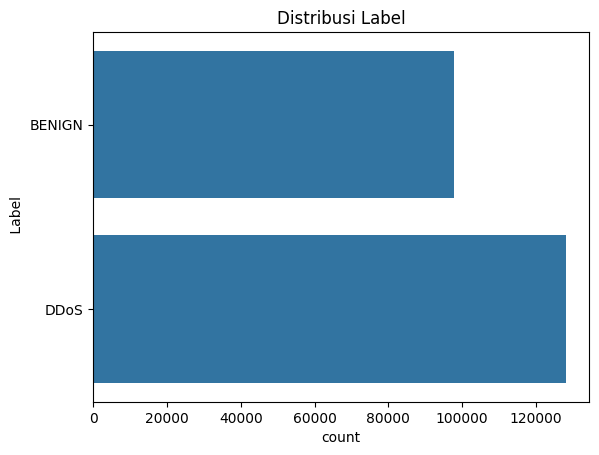

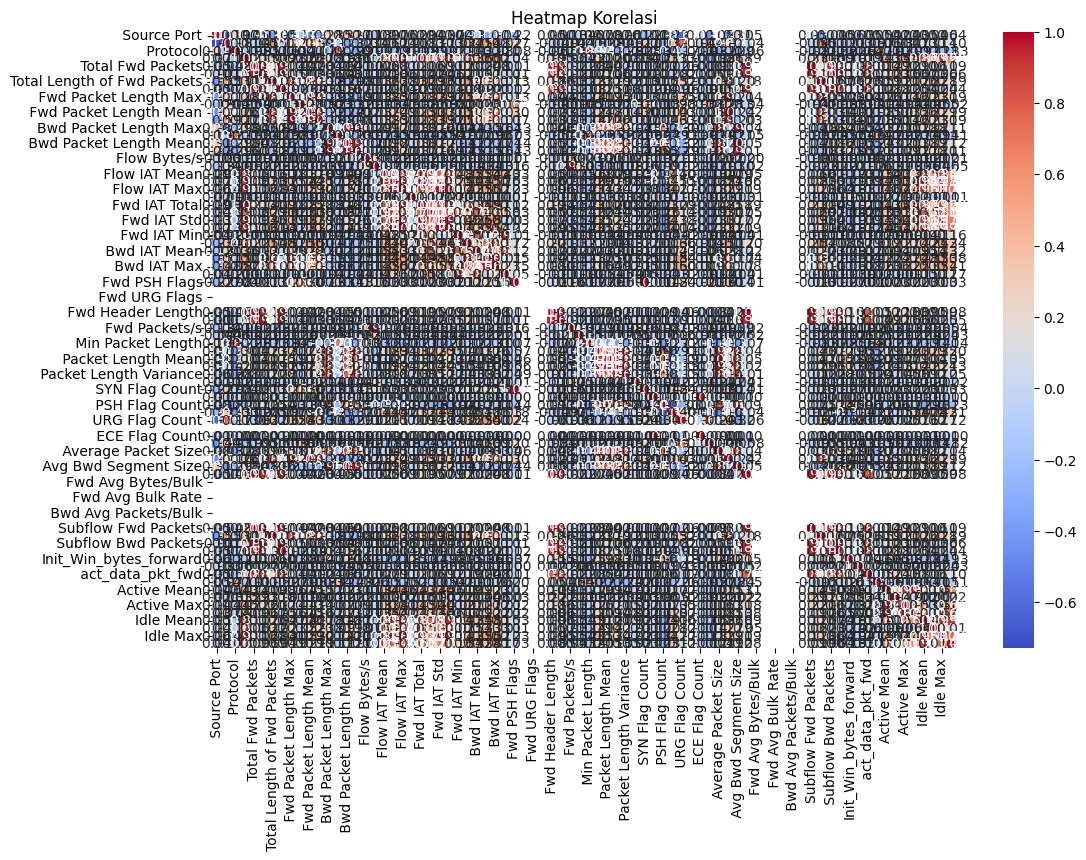

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribusi label
sns.countplot(data[' Label'])
plt.title("Distribusi Label")
plt.show()

# Memilih hanya kolom numerik
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Korelasi antar fitur
corr = numeric_data.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Heatmap Korelasi")
plt.show()


# Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Memuat dataset
file_path = "/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
data = pd.read_csv(file_path)

# 2. Menghapus nilai yang hilang
data = data.dropna()

# 3. Memisahkan fitur dan target
X = data.drop(columns=[' Label'])  # Fitur
y = data[' Label']  # Target

# 4. One-hot encoding untuk target
encoder = OneHotEncoder(sparse_output=False)  # Menggunakan sparse_output=False untuk hasil non-sparse
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# 5. Menangani nilai yang tidak valid (NaN, Inf, atau nilai besar)
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Gantilah Inf dengan NaN

# 6. Memisahkan kolom numerik dan non-numerik
numeric_features = X.select_dtypes(include=[np.number])  # Memilih hanya kolom numerik

# 7. Mengisi NaN pada kolom numerik dengan median kolom
numeric_features.fillna(numeric_features.median(), inplace=True)

# 8. Memilih kolom non-numerik untuk diproses terpisah jika perlu
non_numeric_features = X.select_dtypes(exclude=[np.number])

# 9. Normalisasi fitur numerik
scaler = StandardScaler()
X_normalized = scaler.fit_transform(numeric_features)

# 10. Menyusun kembali dataset dengan fitur numerik yang sudah dinormalisasi
X_processed = pd.concat([pd.DataFrame(X_normalized, columns=numeric_features.columns), non_numeric_features.reset_index(drop=True)], axis=1)

# 11. Memastikan jumlah sampel antara X_processed dan y_encoded konsisten
if X_processed.shape[0] != y_encoded.shape[0]:
    min_samples = min(X_processed.shape[0], y_encoded.shape[0])
    X_processed = X_processed[:min_samples]
    y_encoded = y_encoded[:min_samples]

# 12. Membagi dataset menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# 13. Menyesuaikan bentuk input untuk model CNN (membuat dimensi tambahan untuk channel)
X_train = X_train.values[:, :, np.newaxis]  # Menggunakan .values untuk konversi ke array NumPy dan menambah dimensi
X_test = X_test.values[:, :, np.newaxis]    # Menggunakan .values untuk konversi ke array NumPy dan menambah dimensi

# Menampilkan hasil preprocessing
print("Preprocessing selesai!")
print(f"Shape data training: {X_train.shape}")
print(f"Shape data testing: {X_test.shape}")

# Menampilkan distribusi label setelah encoding
unique_labels = encoder.categories_[0]  # Mendapatkan label unik dari encoder
counts = np.sum(y_encoded, axis=0)       # Menghitung jumlah sampel per label

print("\nDistribusi label setelah encoding:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} sampel")


Preprocessing selesai!
Shape data training: (89559, 84, 1)
Shape data testing: (22390, 84, 1)

Distribusi label setelah encoding:
Label BENIGN: 42313.0 sampel
Label DDoS: 69636.0 sampel


# Model Design

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Membuat model CNN
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_encoded.shape[1], activation='softmax')
])

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 82, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 39, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2432)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         311,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 336,642 (1.28 MB)

 Trainable params: 336,642 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [ ]:
# Pastikan jumlah sampel antara X_processed dan y_encoded konsisten
min_samples = min(X_processed.shape[0], y_encoded.shape[0])
X_processed = X_processed[:min_samples]
y_encoded = y_encoded[:min_samples]

# Pembagian data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Menambahkan dimensi untuk channel (CNN membutuhkan dimensi 3D)
X_train = X_train.values[:, :, np.newaxis]
X_test = X_test.values[:, :, np.newaxis]

# Mengecek dimensi setelah perubahan
print(f"Shape data training: {X_train.shape}")
print(f"Shape data testing: {X_test.shape}")


Shape data training: (89559, 84, 1)
Shape data testing: (22390, 84, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Mengonversi kolom bertipe 'object' menjadi numerik
for column in X_processed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_processed[column] = le.fit_transform(X_processed[column])

# Cek hasil setelah konversi
print(X_processed.dtypes)


 Source Port          float64
 Destination Port     float64
 Protocol             float64
 Flow Duration        float64
 Total Fwd Packets    float64
                       ...   
 Idle Min             float64
Flow ID                 int64
 Source IP              int64
 Destination IP         int64
 Timestamp              int64
Length: 84, dtype: object


In [ ]:
# Mengonversi semua fitur numerik menjadi float32
X_processed = X_processed.astype(np.float32)

# Memastikan tipe data sudah sesuai
print(X_processed.dtypes)


 Source Port          float32
 Destination Port     float32
 Protocol             float32
 Flow Duration        float32
 Total Fwd Packets    float32
                       ...   
 Idle Min             float32
Flow ID               float32
 Source IP            float32
 Destination IP       float32
 Timestamp            float32
Length: 84, dtype: object


In [ ]:
# Pembagian data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Menambahkan dimensi untuk channel (CNN membutuhkan dimensi 3D)
X_train = X_train.values[:, :, np.newaxis]
X_test = X_test.values[:, :, np.newaxis]

# Mengecek dimensi setelah perubahan
print(f"Shape data training: {X_train.shape}")
print(f"Shape data testing: {X_test.shape}")


Shape data training: (89559, 84, 1)
Shape data testing: (22390, 84, 1)


Epoch 1/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 62s 21ms/step - accuracy: 0.8079 - loss: 9.0550 - val_accuracy: 0.9950 - val_loss: 0.0244
Epoch 2/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.9745 - loss: 0.0706 - val_accuracy: 0.9955 - val_loss: 0.0298
Epoch 3/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - accuracy: 0.9784 - loss: 0.0513 - val_accuracy: 0.9916 - val_loss: 0.0341
Epoch 4/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 78s 18ms/step - accuracy: 0.9830 - loss: 0.0465 - val_accuracy: 0.9922 - val_loss: 0.0749
Epoch 5/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 85s 19ms/step - accuracy: 0.9876 - loss: 0.0341 - val_accuracy: 0.9984 - val_loss: 0.0110
Epoch 6/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.9917 - loss: 0.0269 - val_accuracy: 0.9950 - val_loss: 0.0144
Epoch 7/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - accuracy: 0.9923 - loss: 0.0217 - val_accuracy: 0.9993 - val_loss: 0.0127
Epoch 8/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 80s 19ms/step - accuracy: 0.9943 -

Pelatihan selesai!


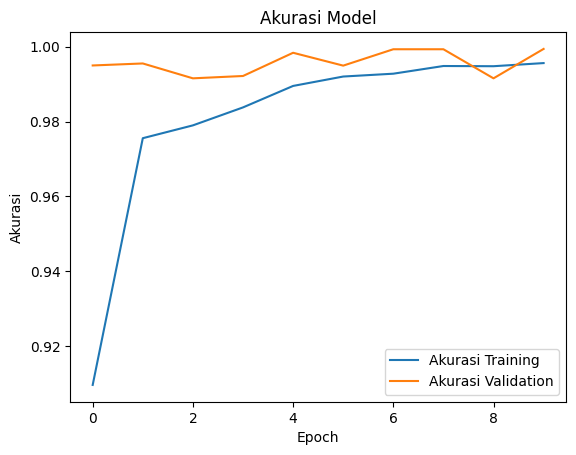

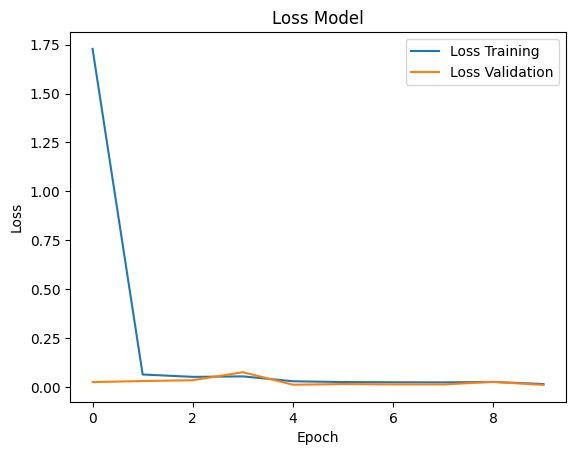

In [ ]:
# Melatih model CNN
history = model.fit(
    X_train,           # Data pelatihan
    y_train,           # Target pelatihan
    epochs=10,         # Jumlah epoch pelatihan
    batch_size=32,     # Ukuran batch
    validation_data=(X_test, y_test),  # Data validasi untuk memantau performa selama pelatihan
    verbose=1          # Menampilkan progress pelatihan
)

# Menyimpan model setelah pelatihan
model.save('/content/cnn_model.h5')

# Pelatihan selesai
print("Pelatihan selesai!")

# Menampilkan grafik akurasi dan loss selama pelatihan
import matplotlib.pyplot as plt

# Akurasi pelatihan dan validasi
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Loss pelatihan dan validasi
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluation Metrics

700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Evaluation Metrics:
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F1-score: 0.9994


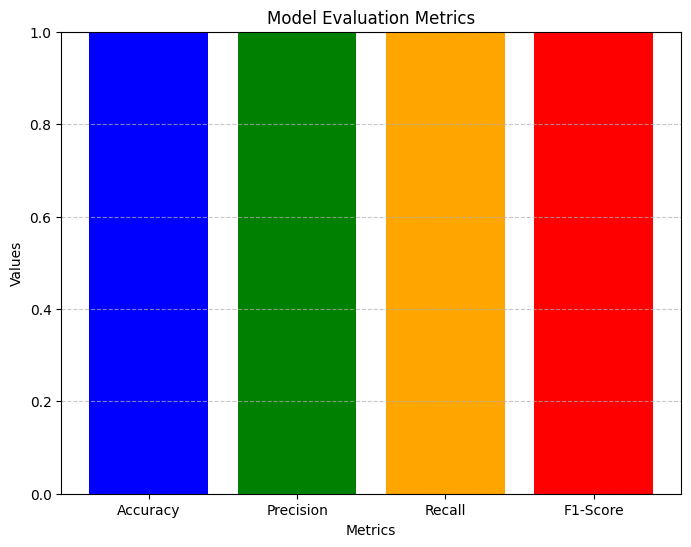

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prediksi pada testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Menampilkan hasil evaluasi dalam bentuk teks
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Menyiapkan data untuk visualisasi
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

# Membuat grafik batang
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)  # Batas nilai metrik
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


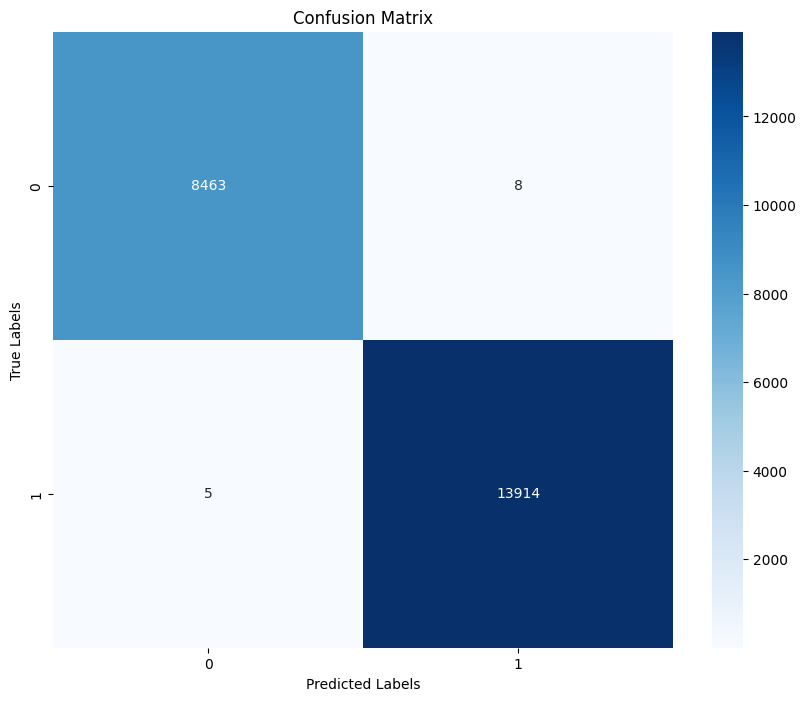

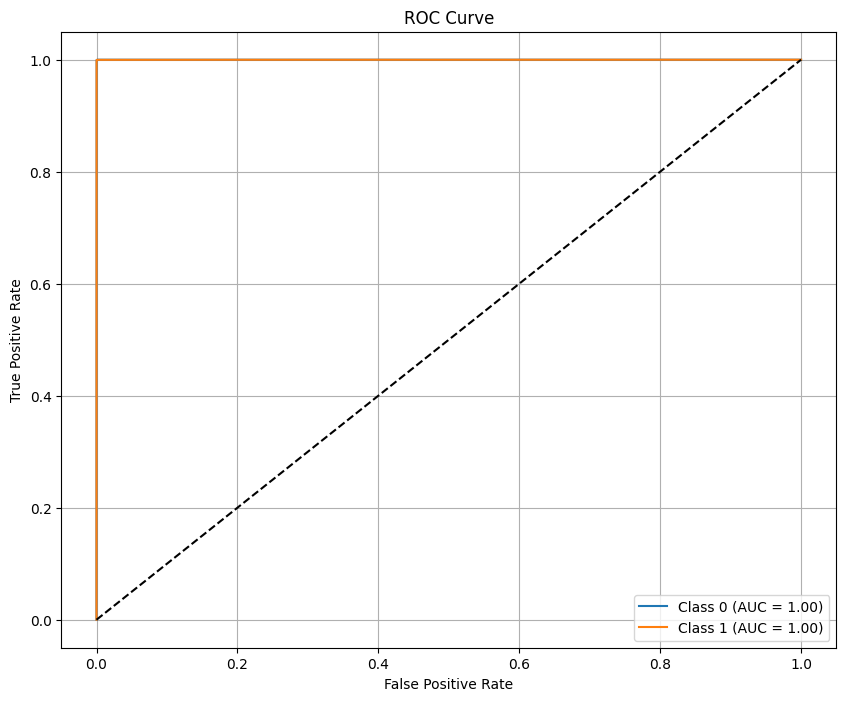

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Prediksi pada testing set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi ke kelas
y_true_classes = np.argmax(y_test, axis=1)  # Label asli

# Menghitung Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Menghitung dan Menampilkan ROC Curve (untuk klasifikasi multi-label)
plt.figure(figsize=(10, 8))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal untuk referensi
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Testing

700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

Evaluation Metrics:
Accuracy: 0.9994
Precision: 0.9994
Recall: 0.9994
F1-score: 0.9994


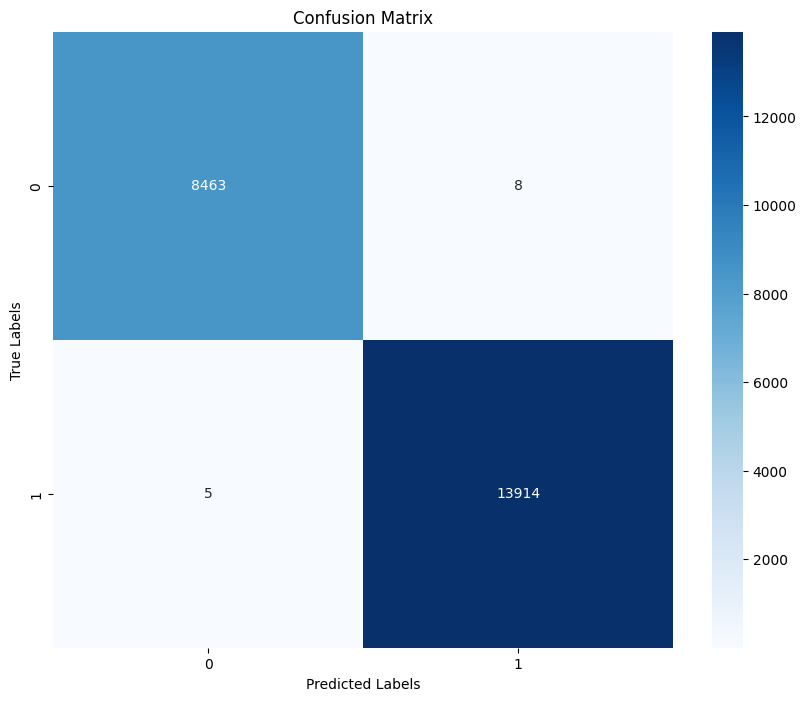

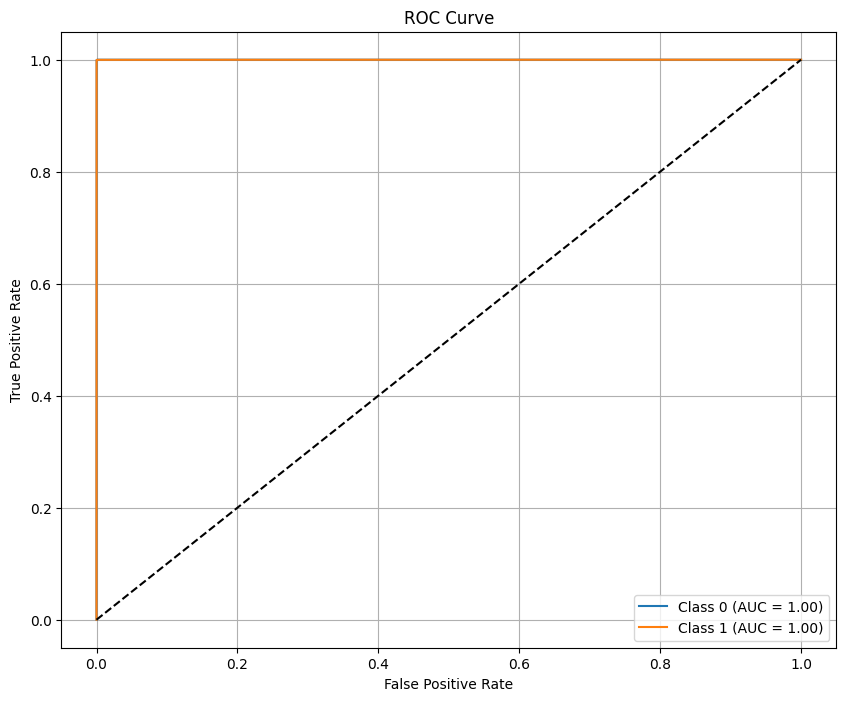

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Pastikan model telah dilatih
if 'model' not in locals():
    from tensorflow.keras.models import load_model
    model = load_model('/content/cnn_model.h5')  # Ganti path sesuai lokasi model Anda

# Prediksi pada data testing
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Konversi probabilitas ke kelas prediksi
y_true_classes = np.argmax(y_test, axis=1)  # Label asli dari one-hot encoding

# 1. Evaluasi Metode Standar
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Print Hasil Evaluasi
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 3. ROC Curve
plt.figure(figsize=(10, 8))
for i in range(y_test.shape[1]):  # Iterasi setiap kelas
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal referensi
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()
